# Histogram Filter: Detailed Explanation and Implementation

This notebook demonstrates the implementation of a histogram filter, a basic type of Bayes filter used for robot localization. The goal is to estimate the position of a robot in a discrete environment (blocks) using probabilities. The robot can sense the world and move between blocks, and we update its probability of being in each block based on these actions.

The histogram filter operates in two main steps:
1. **Sensing**: The robot senses the color of the block it is in (either "red" or "green"). We update the probabilities based on whether the sensed color matches the actual color of each block.
2. **Movement**: The robot moves between blocks. We update the probabilities by shifting the distribution based on the robot's motion and applying some uncertainty.

## Step-by-Step Breakdown

### Step 1: Initial Probability Distribution

We start by assuming the robot can be in any of five blocks. With no prior knowledge, the probability of the robot being in any block is the same for all blocks (uniform distribution). The world is represented by an array of five blocks, each colored either "red" or "green."

**Code Explanation:**
- We initialize the probability distribution with equal probabilities for all blocks.
- We define the world, where each block has a specific color (either "red" or "green").
- We visualize the initial probability distribution using a bar chart.

### Step 2: Sensing Update

The robot can sense the color of the block it's in. We update the probability distribution based on whether the sensed color matches the actual color of each block.
- If the sensed color matches, we multiply the probability of that block by `pHit` (a higher value).
- If it doesn't match, we multiply it by `pMiss` (a lower value).
- Finally, we normalize the probabilities so that they sum to 1.

**Code Explanation:**
- We define a function `sense` that takes the current probabilities and the sensed color as inputs and updates the probabilities accordingly.
- The function checks if the sensed color matches the actual color of each block, updates the probability, and then normalizes the distribution.
- We plot the updated probabilities after sensing "red."

### Step 3: Movement Update

After sensing, the robot moves. We update the probability distribution by shifting it according to the robot's movement. The robot might not move exactly as expected, so we also add uncertainty.
- The `move` function shifts the probabilities by a given number of steps and adds uncertainty by applying a convolution with a predefined uncertainty distribution.

**Code Explanation:**
- We first implement a basic `move` function that shifts the probability distribution by a specified number of blocks.
- We plot the probabilities after moving the robot by two blocks.
- We then extend the function to include movement uncertainty by convolving the distribution with an uncertainty kernel.
- We plot the updated distribution after movement with uncertainty.

### Step 4: Repeated Movements Without Sensing

We simulate the robot moving multiple times without sensing the world. The robot's position becomes less certain over time, as no new measurements are taken to correct its position.

**Code Explanation:**
- We move the robot 1000 times without taking any measurements.
- The `move` function is repeatedly applied, and the probability distribution becomes more spread out and uncertain over time.
- We plot the final probabilities after 1000 movements.

### Step 5: Full Histogram Filter Implementation

Finally, we combine sensing and movement. The robot alternates between sensing the world and moving, and we update the probability distribution after each step.

**Code Explanation:**
- We reset the initial probabilities and define a sequence of measurements and movements.
- For each measurement and movement, we update the probabilities using the `sense` and `move` functions.
- We plot the final probability distribution after both sensing and moving.

### Exercise 1: Extending the Filter to 2D

In this exercise, we extend the histogram filter to work in a 2D world. The robot can now move up, down, left, and right in a 4x5 grid. The probability distribution and the world are represented as 2D arrays.

**Code Explanation:**
- We define a 2D grid for the probabilities and the world (4x5 blocks), where each block is either "red" or "green."
- The `sense_2d` function updates the 2D probability distribution based on the sensed color.
- The `move_2d` function shifts the probabilities in the specified direction (up, down, left, or right) and adds movement uncertainty using a 2D convolution.
- We loop through a series of movements and measurements, updating and plotting the probability distribution after each step.
- The final probability distribution is visualized using heatmaps (`plt.imshow`), showing how the robot's position evolves over time.

### Conclusion

This notebook demonstrates how to implement and extend a histogram filter for robot localization. By combining sensing and movement, we can estimate the robot's position over time, even in the presence of uncertainty. The final exercise showed how this can be extended to more complex environments, such as 2D grids.


# Histogram filter

Assume we have a robot that can be in one of five blocks. With no other info, we calculate the initial probability of the robot being in each block and plot a histogram of the probabilities:

In [1]:
from math import *
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, signal

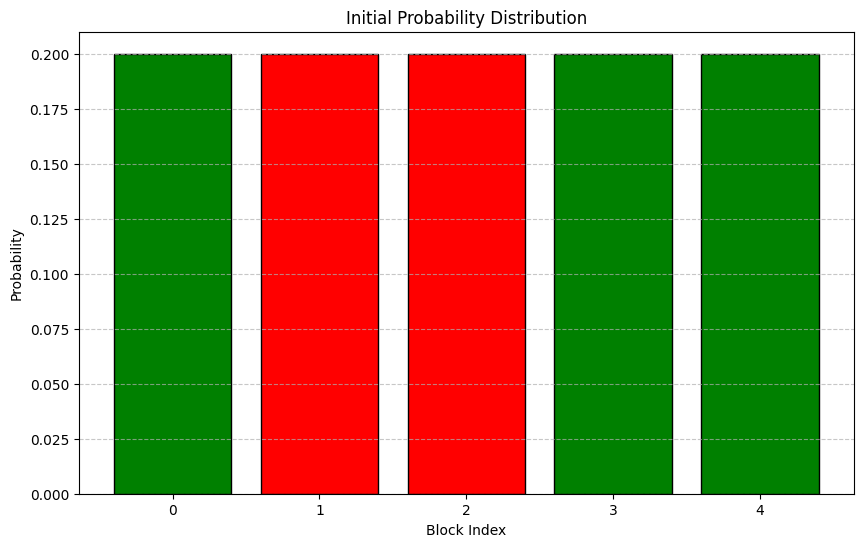

In [2]:
# Number of blocks in the environment
no_of_blocks = 5
# Initial probability of being in any block is uniform
prb = 1 / no_of_blocks
p = [prb] * no_of_blocks

# Defining the world: each block has a color
world = ['green', 'red', 'red', 'green', 'green']
colors = ['green' if world[i] == 'green' else 'red' for i in range(no_of_blocks)]

# Plotting the initial probabilities
plt.figure(figsize=(10, 6))
plt.bar(range(no_of_blocks), p, color=colors, edgecolor='black')
plt.xlabel('Block Index')
plt.ylabel('Probability')
plt.title('Initial Probability Distribution')
plt.xticks(range(no_of_blocks))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Sensing Update
Each block is either red or green, and the robot can sense the color. We update the probability distribution based on the sensor readings.
If the measurement matches the block color, we multiply by `pHit`, otherwise by `pMiss`.
We normalize the probabilities to ensure they sum to 1.

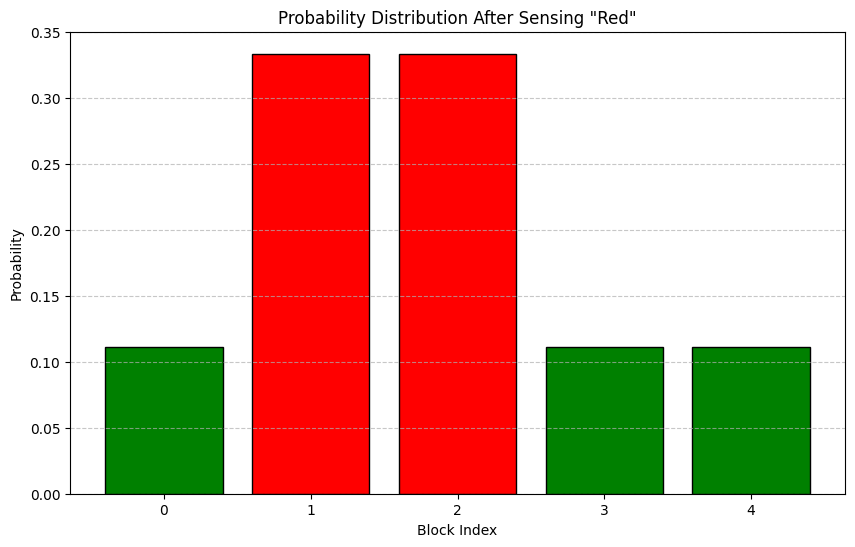

In [3]:
# Measurement taken by the robot
z = 'red' 
# Probabilities for correct and incorrect measurements
pHit = 0.6
pMiss = 0.2

def sense(p, z):
    """
    Update the probability distribution based on the sensor reading.
    Args:
    - p: List of probabilities for each block.
    - z: Measured color ('red' or 'green').

    Returns:
    - Updated probability distribution (list).
    """
    q = []
    for i in range(len(world)):
        # Determine if the measurement matches the block color
        hit = (z == world[i])
        # Update probability based on hit or miss
        q.append(p[i] * (hit * pHit + (1 - hit) * pMiss))
    
    # Normalize to ensure the probabilities sum to 1
    q = np.array(q) / sum(q)
    return q

# Update probabilities based on the measurement
q = sense(p, z)

# Plotting the updated probabilities with world colors
plt.figure(figsize=(10, 6))
plt.bar(range(no_of_blocks), q, color=colors, edgecolor='black')
plt.xlabel('Block Index')
plt.ylabel('Probability')
plt.title('Probability Distribution After Sensing "Red"')
plt.xticks(range(no_of_blocks))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Movement Update
We define a function to move the robot and update the probability distribution accordingly using `numpy.roll`.
This function shifts the probabilities by `U` steps.

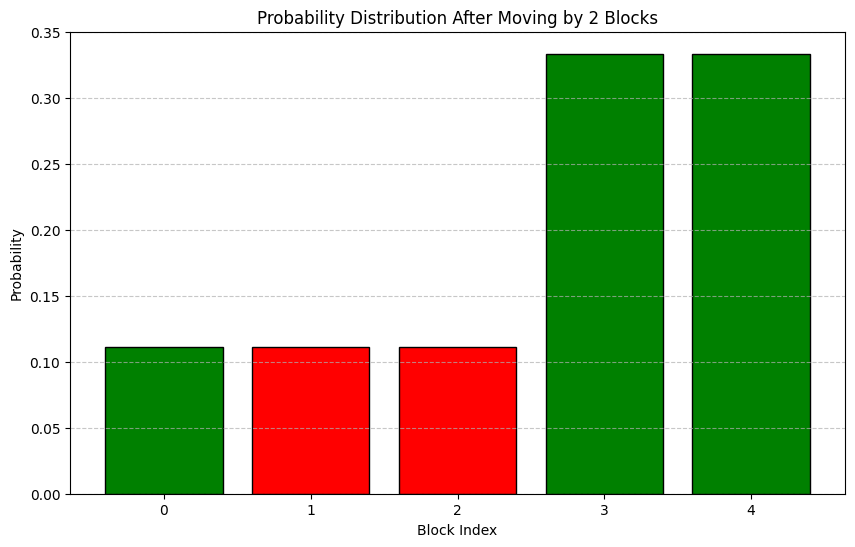

In [4]:
def move(p, U):
    """
    Move the robot by shifting the probability distribution.
    Args:
    - p: List of probabilities for each block.
    - U: Number of steps to move (positive for right, negative for left).

    Returns:
    - Updated probability distribution after movement (list).
    """
    # Shift the probabilities by U steps
    q = np.roll(p, U)
    return q

# Move the robot by 2 blocks
q = move(q, 2)

# Plotting the probabilities after movement
plt.figure(figsize=(10, 6))
plt.bar(range(no_of_blocks), q, color=colors, edgecolor='black')
plt.xlabel('Block Index')
plt.ylabel('Probability')
plt.title('Probability Distribution After Moving by 2 Blocks')
plt.xticks(range(no_of_blocks))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

There is uncertainty in movement, which we add by convolving the movement probabilities with a predefined uncertainty distribution.

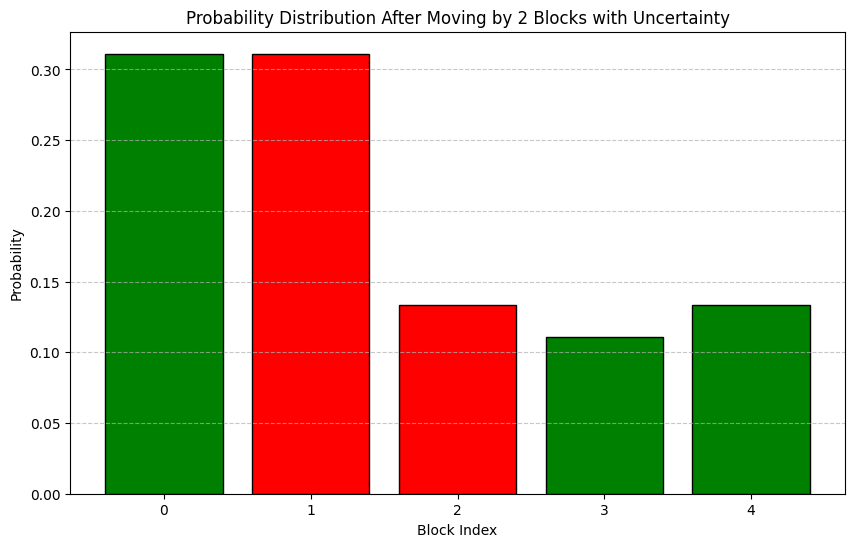

In [5]:
# Defining the movement uncertainty distribution
move_uncertainty = [0.1, 0.8, 0.1]

def move(p, U, move_uncertainty):
    """
    Move the robot with added movement uncertainty.
    Args:
    - p: List of probabilities for each block.
    - U: Number of steps to move.
    - move_uncertainty: List defining the uncertainty distribution for movement.

    Returns:
    - Updated probability distribution after movement with uncertainty (list).
    """
    # Shift the probabilities by U steps
    q = np.roll(p, U)
    # Convolve with movement uncertainty to add noise
    q = ndimage.convolve1d(q, move_uncertainty, mode='wrap')
    return q

# Move the robot by 2 blocks with uncertainty
q = move(q, 2, move_uncertainty)

# Plotting the probabilities after movement with uncertainty
plt.figure(figsize=(10, 6))
plt.bar(range(no_of_blocks), q, color=colors, edgecolor='black')
plt.xlabel('Block Index')
plt.ylabel('Probability')
plt.title('Probability Distribution After Moving by 2 Blocks with Uncertainty')
plt.xticks(range(no_of_blocks))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Repeated Movements Without Sensing
Let us now move the robot a thousand times without sensing anything and observe the resulting distribution.

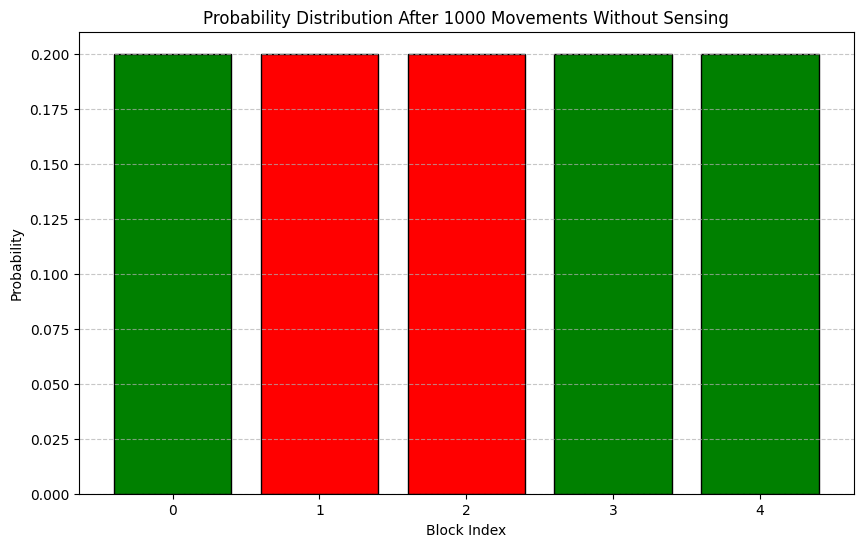

In [6]:
# Moving the robot 1000 times
for i in range(1000):
    q = move(q, 2, move_uncertainty)

# Plotting the probabilities after 1000 movements
plt.figure(figsize=(10, 6))
plt.bar(range(no_of_blocks), q, color=colors, edgecolor='black')
plt.xlabel('Block Index')
plt.ylabel('Probability')
plt.title('Probability Distribution After 1000 Movements Without Sensing')
plt.xticks(range(no_of_blocks))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Full Histogram Filter Implementation
We now combine sensing and movement steps. We update the probabilities by sensing, followed by movement, iteratively.

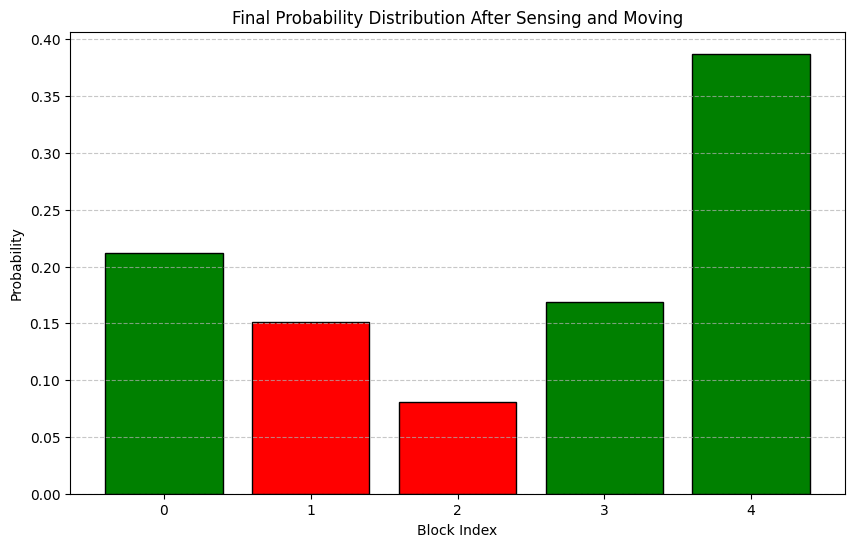

In [7]:
# Resetting initial probabilities
p = [prb] * no_of_blocks

# Defining the sequence of measurements and movements
measurements = ['red', 'green']
movements = [1, 1]

# Loop through the measurements and movements
for i in range(len(movements)):
    p = sense(p, measurements[i])  # Update probabilities based on sensing
    p = move(p, movements[i], move_uncertainty)  # Update probabilities based on movement

# Plotting the final probabilities
plt.figure(figsize=(10, 6))
plt.bar(range(no_of_blocks), p, color=colors, edgecolor='black')
plt.xlabel('Block Index')
plt.ylabel('Probability')
plt.title('Final Probability Distribution After Sensing and Moving')
plt.xticks(range(no_of_blocks))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Exercise 1
We will now extent the histogram plot to work in 2D. You are given the world map and the move function below. We can now move up, down, left and right in the world. We can plot the map with the probabilities by using plt.imshow.
Insert a sense function that will work in 2D, and loop through the measurements and movements, while showing the probabilities using plt.imshow. You will also need to insert a 2D version of the move_uncertainty.

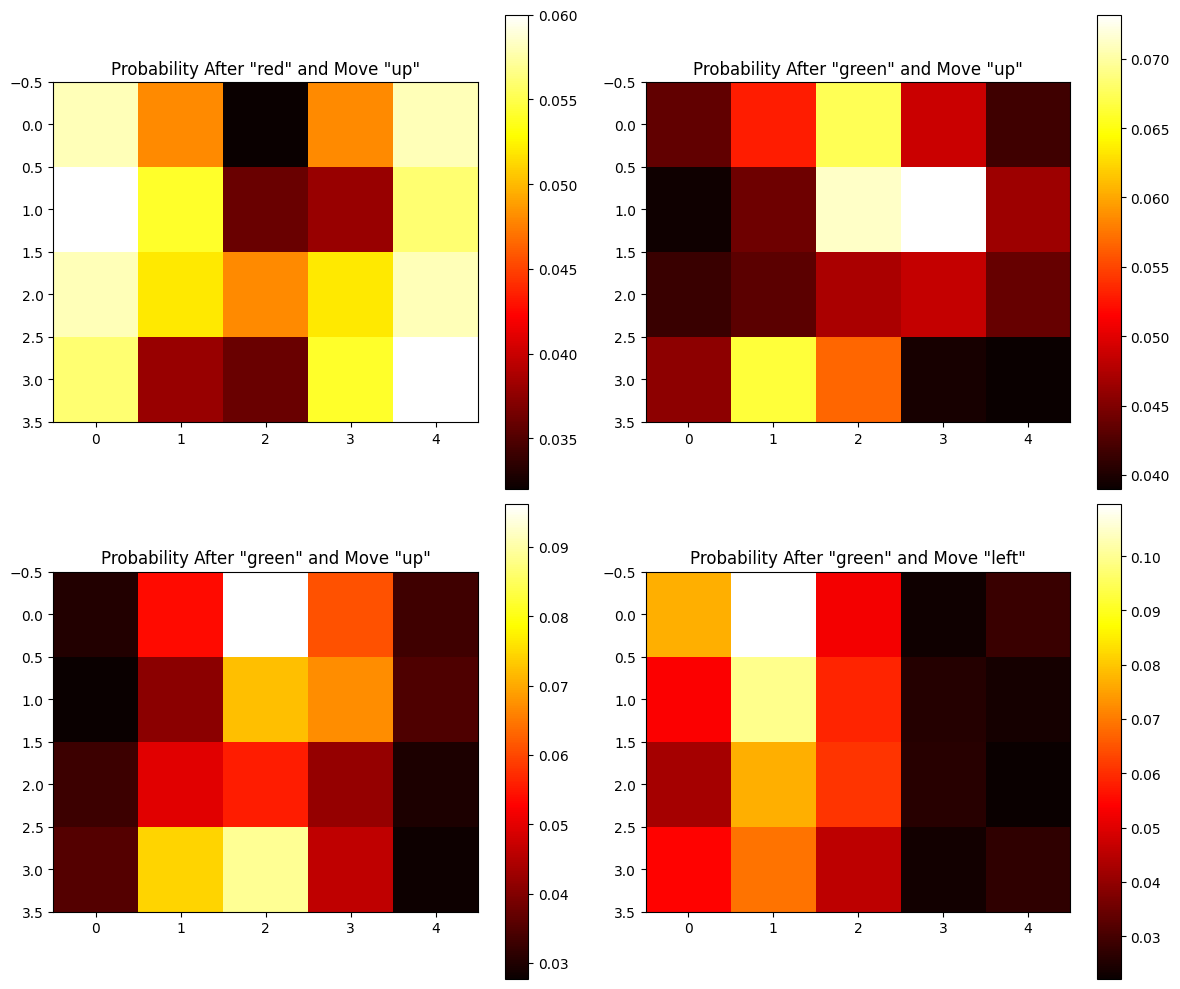

In [8]:
no_of_blocks = 20
prb = 1 / 20

# The initial probabilities (4x5 grid)
p = [[prb, prb, prb, prb, prb],
     [prb, prb, prb, prb, prb],
     [prb, prb, prb, prb, prb],
     [prb, prb, prb, prb, prb]]

# The world map (4x5 grid of colors)
world = [['red', 'green', 'green', 'red', 'red'],
         ['red', 'red', 'green', 'red', 'red'],
         ['red', 'red', 'green', 'green', 'red'],
         ['red', 'red', 'red', 'red', 'red']]

# Measurements and movements
measurements = ['red', 'green', 'green', 'green']
pHit = 0.6
pMiss = 0.2
movements = ['up', 'up', 'up', 'left']

# Define move uncertainty (3x3 kernel)
move_uncertainty = [[0.05, 0.1, 0.05],
                    [0.1, 0.4, 0.1],
                    [0.05, 0.1, 0.05]]


def sense_2d(p, z):
    """
    Update the 2D probability distribution based on the sensor reading.
    Args:
    - p: 2D list of probabilities for each cell.
    - z: Measured color ('red' or 'green').

    Returns:
    - Updated 2D probability distribution (numpy array).
    """
    q = []
    for i in range(len(p)):
        q_row = []
        for j in range(len(p[i])):
            hit = (z == world[i][j])
            q_row.append(p[i][j] * (hit * pHit + (1 - hit) * pMiss))
        q.append(q_row)
    
    # Normalize to ensure the probabilities sum to 1
    q = np.array(q)
    q = q / np.sum(q)
    return q


def move_2d(p, u, move_uncertainty):
    """
    Move the robot in 2D space with added movement uncertainty.
    Args:
    - p: 2D list of probabilities for each cell.
    - u: Direction to move ('up', 'down', 'left', 'right').
    - move_uncertainty: 2D list defining the uncertainty distribution for movement.

    Returns:
    - Updated 2D probability distribution after movement with uncertainty (numpy array).
    """
    if u == 'up':
        q = np.roll(p, -1, axis=0)
    elif u == 'down':
        q = np.roll(p, 1, axis=0)
    elif u == 'right':
        q = np.roll(p, 1, axis=1)
    elif u == 'left':
        q = np.roll(p, -1, axis=1)
    
    # Convolve with movement uncertainty to add noise
    q = signal.convolve2d(q, move_uncertainty, boundary='wrap', mode='same')
    return q

# Loop through the measurements and movements
plt.figure(figsize=(12, 10))
for i in range(len(movements)):
    # Update probabilities based on sensing
    p = sense_2d(p, measurements[i])
    # Update probabilities based on movement
    p = move_2d(p, movements[i], move_uncertainty)
    
    # Plot the probabilities
    plt.subplot(2, 2, i + 1)
    plt.imshow(p, cmap='hot', interpolation='nearest')
    plt.title(f'Probability After "{measurements[i]}" and Move "{movements[i]}"')
    plt.colorbar()

plt.tight_layout()
plt.show()